In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import torch_geometric as pyg
import numpy as np
import pandas as pd
import torch_geometric as pyg
import hydra
from hydra.core.global_hydra import GlobalHydra
import os
from tqdm import tqdm
os.environ["HYDRA_FULL_ERROR"] = "1"


from mil.data.mnist import MNISTBags, OneHotMNISTBags, MNISTCollage, OneHotMNISTCollage
from mil.utils import device, human_format, set_seed
from mil.utils.visualize import print_one_hot_bag_with_attention, print_one_hot_bag, plot_attention_head, plot_bag, plot_one_hot_collage
from mil.utils.stats import print_prediction_stats
from mil.utils.layers import find_submodule
from mil.models.abmil import WeightedAverageAttention
from mil.models.self_attention import MultiHeadSelfAttention
from mil.models.distance_aware_self_attention import DistanceAwareSelfAttentionHead
from mil.models.mil import MILModel
from train import instantiate_loss_function, History, train_step, test

RESULTS_FILE = "train.csv"

GlobalHydra().clear()
hydra.initialize(config_path="conf")
cfg = hydra.compose("config.yaml", overrides=["+experiment=mnist_bags", "+model=self_attention"])

set_seed(cfg.seed)

/Users/georg/Projects/mil/mil_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/75/85q4yvfd39z3s95j568dmh640000gn/T/ipykernel_93046/2511676386.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="conf")


# MNIST bags / MNIST collage

## Instantiate datasets and loaders

In [2]:
train_dataset = hydra.utils.instantiate(cfg.dataset.train)
test_dataset = hydra.utils.instantiate(cfg.dataset.test)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=True, collate_fn=lambda x: x[0], num_workers=0, pin_memory=False)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: x[0], num_workers=0, pin_memory=False)

## Define the model

The three parts of the MIL model are:
1. **feature extractor**: extract a feature vector $z \in \mathbb{R}^D$ from each instance. In the case of the one-hot dataset, this is just the identity function. For the actual *mnist-bags* dataset, this is a CNN.
2. **pooling**: a function $f : \mathbb{R}^{N \times D} \to \mathbb{R}^D$ that aggregates the $N$ feature vectors in the bag to a single feature vector.
3. **classifier**: a function $g : \mathbb{R}^D \to \mathbb{R}$ that transforms the aggregated feature vector into a binary classification prediction (we parameterise $g$ using a linear layer followed by a sigmoid)


In [3]:
import typing
from mil.utils import identity
from torch import nn
import torch
from torch_geometric.data import Data

class DefaultClassifier(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return self.linear(x.sum(-2))

class AdditiveClassifier(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        instance_logits = self.linear(x).squeeze(-1)
        self.instance_logits = instance_logits.detach()
        return instance_logits.sum(-1)

model = MILModel(
    feature_extractor=hydra.utils.instantiate(cfg.model.feature_extractor),
    pooler=pyg.nn.Sequential("x, edge_index, edge_attr, pos", [
        (
            # ABMIL(feature_size=cfg.settings.feature_size, hidden_dim=cfg.settings.hidden_dim),
            MultiHeadSelfAttention(feature_size=cfg.settings.feature_size, hidden_dim=cfg.settings.hidden_dim, output_size=cfg.settings.feature_size),
            "x -> x"
        )
    ]),
    # classifier=DefaultClassifier(input_dim=cfg.settings.feature_size),
    classifier=AdditiveClassifier(input_dim=cfg.settings.feature_size),
    logit_to_prob=hydra.utils.instantiate(cfg.model.logit_to_prob)
)

# model = hydra.utils.instantiate(cfg.model, _convert_="partial")
attention_layer = find_submodule(model, (WeightedAverageAttention, MultiHeadSelfAttention, DistanceAwareSelfAttentionHead))
classifier = find_submodule(model, (DefaultClassifier, AdditiveClassifier))


## Define loss function and optimizer

We use binary cross-entropy loss.

In [4]:
loss_function = instantiate_loss_function(cfg, train_dataset)
optimizer = hydra.utils.instantiate(cfg.optimizer, model.parameters())

2023-06-14 15:47:04.331 | INFO     | train:instantiate_loss_function:142 - Using pos_weight=1.000 in loss function


## Train

In [5]:
train_history = History()
test_history = History()
stats = []

model.train()
num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Training model with {human_format(num_parameters)} parameters")

for epoch in range(cfg.num_epochs):
    model.train()

    train_history.reset()
    test_history.reset()

    # # Biggest bag first to avoid CUDA OOM
    # if isinstance(train_dataset, Camelyon16Dataset):
    #     train_step(
    #         cfg,
    #         -1,
    #         train_dataset.fake_bag(),
    #         model,
    #         loss_function,
    #         optimizer,
    #         history=None,
    #         update=False,
    #     )

    # Train
    for i, bag in enumerate(train_loader):
        train_step(cfg, i, bag, model, loss_function, optimizer, train_history)

    # Test
    predictions = test(cfg, model, loss_function, test_loader, test_history, pbar=False, return_predictions=True)

    log = {
        "epoch": epoch,
        **{f"train/{k}": v for k, v in train_history.compute_metrics().items()},
        **{f"test/{k}": v for k, v in test_history.compute_metrics().items()},
    }
    stats.append(log)
    LOG_KEYS = {"train/acc", "test/acc", "train/loss", "test/loss"}
    print(
        f"Epoch: {epoch:3d},",
        ", ".join(
            f"{k}: {v:.4f}" for k, v in log.items() if k in LOG_KEYS
        ),
    )

# Plot training and test loss/error
stats = pd.DataFrame(stats)
float_cols = [col for col in stats.columns if col != "epoch"]
stats[float_cols] = stats[float_cols].astype(float)
stats.to_csv(RESULTS_FILE, index=False)

Training model with 17.2K parameters
Epoch:   0, train/acc: 0.4767, train/loss: 0.7102, test/acc: 0.5500, test/loss: 0.6844
Epoch:   1, train/acc: 0.5967, train/loss: 0.6710, test/acc: 0.7300, test/loss: 0.5815
Epoch:   2, train/acc: 0.6867, train/loss: 0.5937, test/acc: 0.7700, test/loss: 0.5251
Epoch:   3, train/acc: 0.7600, train/loss: 0.5218, test/acc: 0.8800, test/loss: 0.3676
Epoch:   4, train/acc: 0.8267, train/loss: 0.4260, test/acc: 0.9100, test/loss: 0.2586
Epoch:   5, train/acc: 0.8633, train/loss: 0.3267, test/acc: 0.9600, test/loss: 0.2010
Epoch:   6, train/acc: 0.8800, train/loss: 0.3437, test/acc: 0.9500, test/loss: 0.2396
Epoch:   7, train/acc: 0.9067, train/loss: 0.2405, test/acc: 0.9200, test/loss: 0.2335
Epoch:   8, train/acc: 0.9367, train/loss: 0.2364, test/acc: 0.9500, test/loss: 0.2589
Epoch:   9, train/acc: 0.9233, train/loss: 0.2466, test/acc: 0.9500, test/loss: 0.1836
Epoch:  10, train/acc: 0.9333, train/loss: 0.2075, test/acc: 0.9300, test/loss: 0.2195
Epoch:

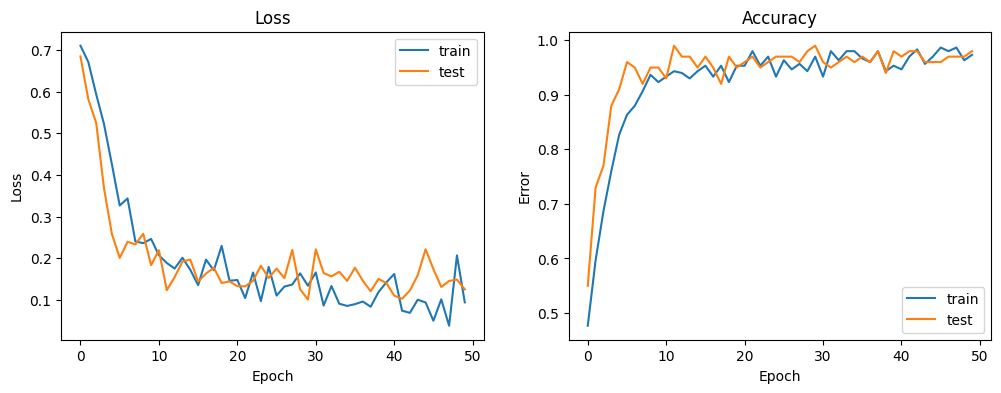

In [6]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("Loss")
plt.plot(stats["epoch"], stats["train/loss"], label="train")
plt.plot(stats["epoch"], stats["test/loss"], label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(122)
plt.title("Accuracy")
plt.plot(stats["epoch"], stats["train/acc"], label="train")
plt.plot(stats["epoch"], stats["test/acc"], label="test")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()

## Test

In [7]:
print_prediction_stats(predictions, target_numbers=cfg.settings.mnist.target_numbers)


                                 % acc    total    -pred    +pred     example
  bags                              98      100       50       50     0 8 8 5 6 0 3 6 4 9
  bags with 0s                      98       71       22       49     0 8 8 5 6 0 3 6 4 9
  bags without 0s                   96       29       28        1     9 3 1 2 8 9
  bags with 0s and 1s               98       50        1       49     0 3 5 9 0 3 6 5 1 1 8
  bags with 0s and not 1s          100       21       21        0     0 8 8 5 6 0 3 6 4 9
  bags with 0s or 1s                97       93       43       50     0 8 8 5 6 0 3 6 4 9
  bags with 1s                      97       72       22       50     0 3 5 9 0 3 6 5 1 1 8
  bags without 1s                  100       28       28        0     0 8 8 5 6 0 3 6 4 9
  bags with 1s and 0s               98       50        1       49     0 3 5 9 0 3 6 5 1 1 8
  bags with 1s and not 0s           95       22       21        1     9 3 1 2 8 9
  bags with 1s or 0s           

### First 10 bags in test dataset

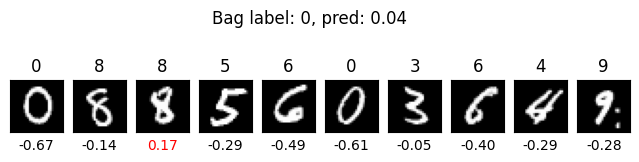

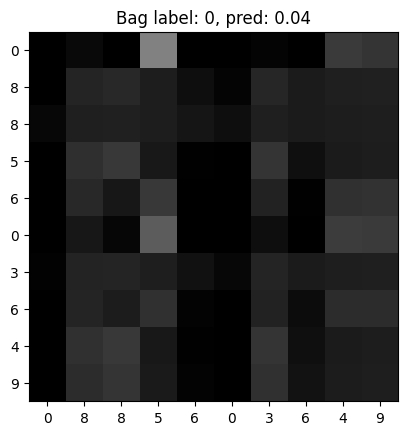

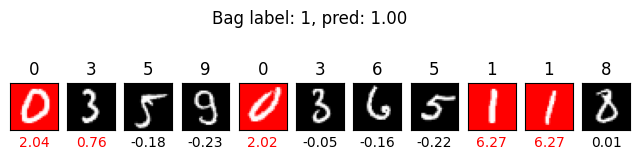

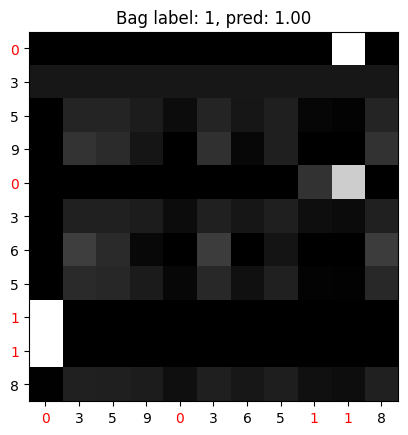

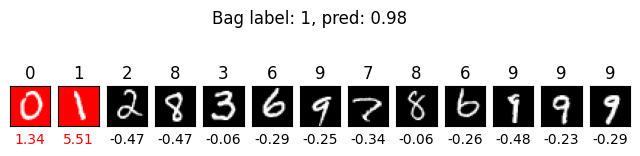

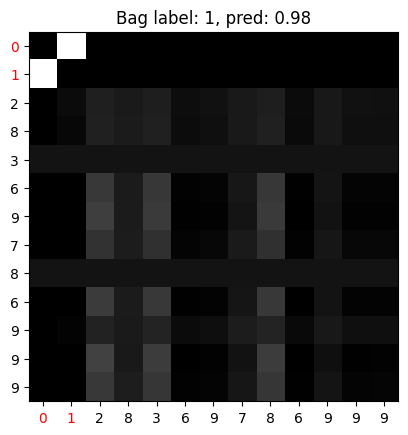

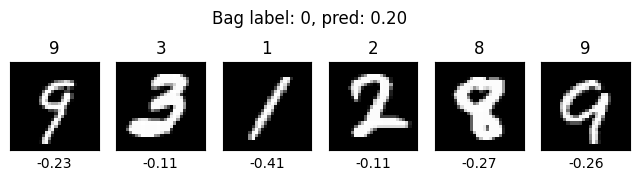

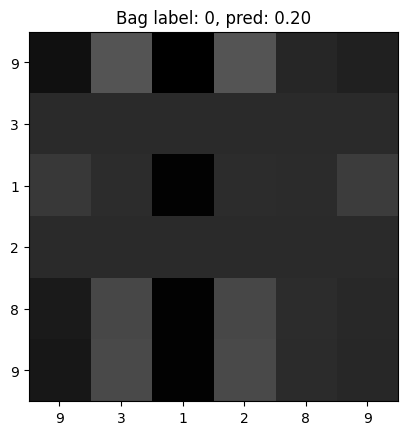

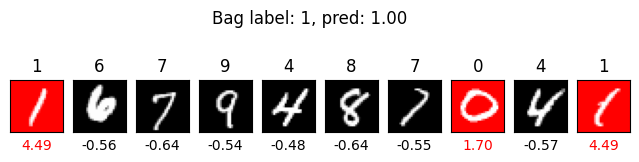

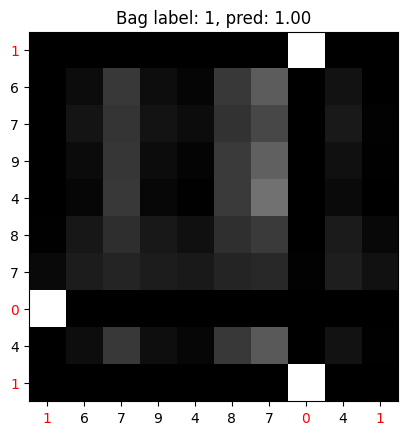

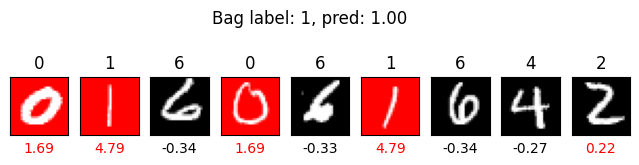

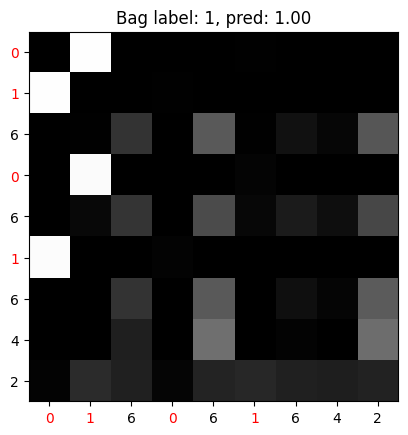

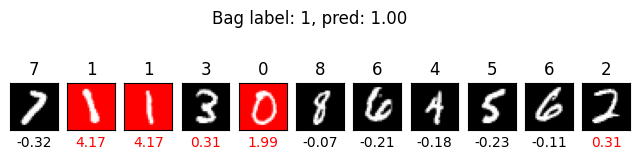

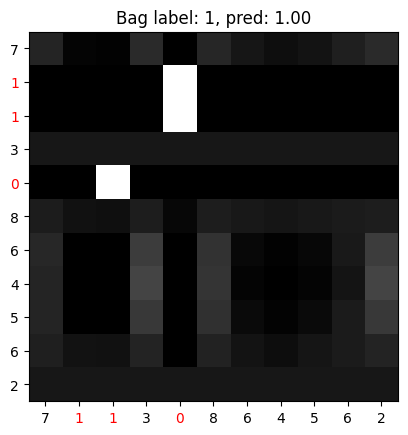

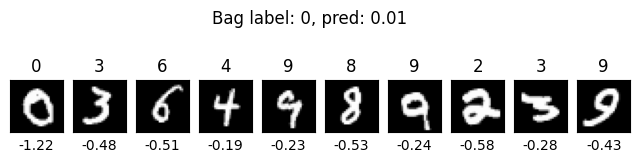

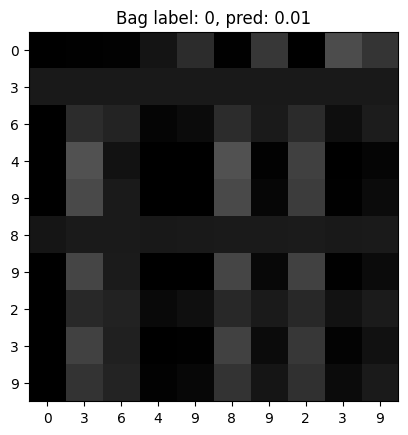

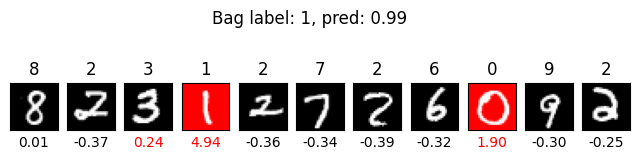

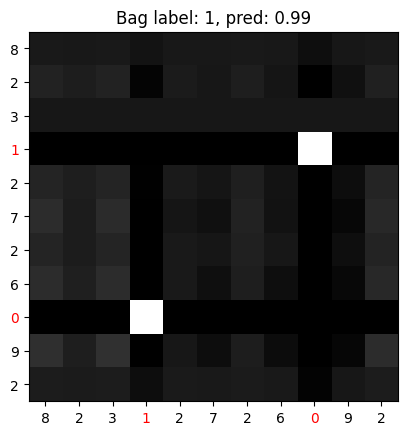

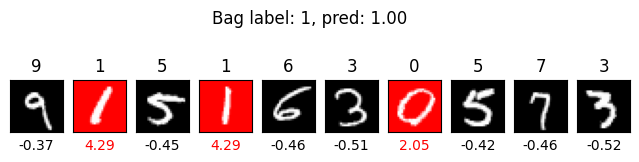

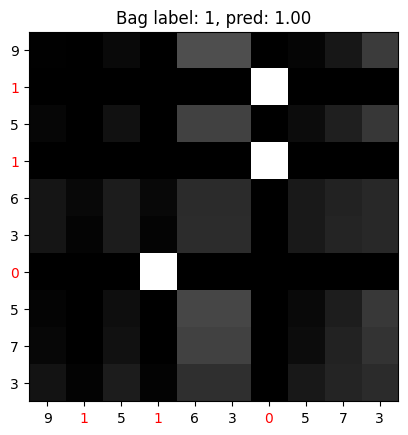

In [9]:
def plot_dist_aware_attention(bag):
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")
    plt.subplot(141)
    plt.title("dist")
    data = attention_layer.data
    dist = pyg.utils.to_dense_adj(data.edge_index, edge_attr=data.edge_attr.squeeze(-1), max_num_nodes=data.num_nodes).squeeze(0)  # NxN
    plot_attention_head(bag, dist, limit_range=False)
    plt.subplot(142)
    plt.title("A0")
    plot_attention_head(bag, attention_layer.A0)
    plt.subplot(143)
    plt.title("A")
    plot_attention_head(bag, attention_layer.A)

def visualize_prediction(bag, y_pred):
    y = bag.y
    if isinstance(train_dataset, OneHotMNISTBags):
        if isinstance(attention_layer, WeightedAverageAttention):
            print_one_hot_bag_with_attention(bag, attention_layer.A, y_pred>.5)
            print()
        elif isinstance(attention_layer, MultiHeadSelfAttention):
            plt.figure()
            plot_attention_head(bag, attention_layer.A[0])
            plt.title(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")
        else:
            print_one_hot_bag(bag, y_pred>.5)
    elif isinstance(train_dataset, MNISTBags):
        if isinstance(attention_layer, WeightedAverageAttention):
            plot_bag(bag, y_pred=y_pred, attention=attention_layer.A.squeeze(-1))
        elif isinstance(attention_layer, MultiHeadSelfAttention):
            attention = None
            if isinstance(classifier, AdditiveClassifier):
                attention = classifier.instance_logits
            plot_bag(bag, y_pred=y_pred, attention=attention)
            plt.figure()
            plot_attention_head(bag, attention_layer.A[0])
            plt.title(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")
        else:
            plot_bag(bag, y_pred=y_pred)
    elif isinstance(train_dataset, OneHotMNISTCollage):
        plt.figure()
        plot_one_hot_collage(bag, y_pred=y_pred)
        plt.title(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")
        if isinstance(attention_layer, DistanceAwareSelfAttentionHead):
            plot_dist_aware_attention(bag)
    elif isinstance(train_dataset, MNISTCollage):
        plot_bag(bag, y_pred=y_pred, collage_size=COLLAGE_SIZE)
        if isinstance(attention_layer, DistanceAwareSelfAttentionHead):
            plot_dist_aware_attention(bag)

# Visualize first 10 bags
model.eval()
with torch.no_grad():
    for bag in itertools.islice(test_loader, 10):
        bag = device(bag)
        y = bag.y.float()
        y_pred, y_pred_logit = model(bag)
        visualize_prediction(bag, y_pred.squeeze(0))

### First 10 mistakes in test dataset

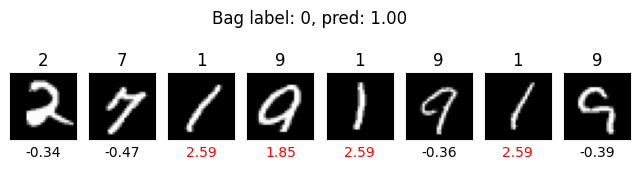

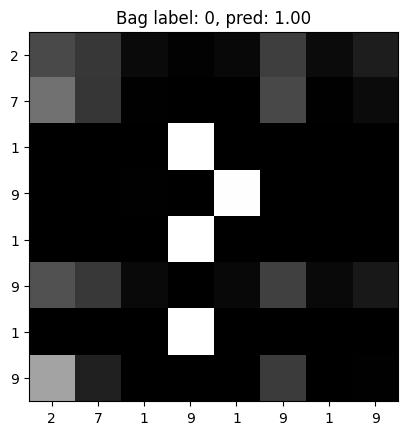

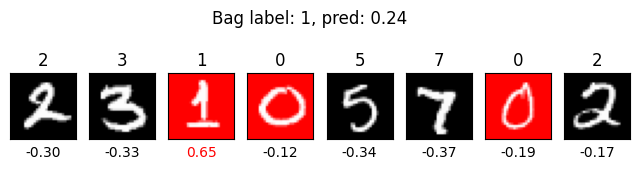

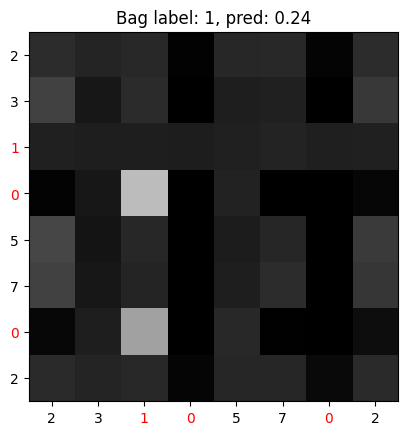

In [13]:
# Visualize first 10 mistakes
model.eval()
with torch.no_grad():
    i = 0
    for bag in test_loader:
        if i == 10:
            break
        bag = device(bag)
        y = bag.y.float()
        y_pred, y_pred_logit = model(bag)
        if ((y_pred > .5).float() != y).cpu().detach():
            visualize_prediction(bag, y_pred.squeeze(0))
            i += 1